# Classifiers for What's Cooking

This file implements the following classifiers for the What's Cooking challenge, in an attempt to match the accuracy benchmarks noted below, from Ghewani-Raiyani (ref 1 in our brief):

**KNN** - 60.75% <br>
**Decision Tree** - 62.59% <br>
**Naive Bayes** - 73.25% <br>
**Random Forest** 74.13%  with an accuracy of the second paper claims accuracy of 76.2% using diff features. <br> 
**Logistic Regression** - 81.25% <br>
**SVM** - 81.32% <br>

Note that as labels for the test set are not available, the above benchmarks represent accuracy on the validation set. 

## Exec Summary

At present the analysis shows that even using a very simplistic pipeline featuring a CountVectorizer on the untransformed read-in data followed by un-tuned classifiers we can achieve results within 4ppts of the benchmarks, as tested on a single validation fold. 

## Further Work

1. I believe the greatest results will be achieved by improving the feature selection stage. At present the vectoriser selects individual words (so 'ground black pepper' would count towards each of the 'ground','black' and 'pepper' tokens) and there has been no modification done on the ingredients. Automated approaches could look at reducing number of features, concatenating, combining phrases with a high degree similarity etc. Manual approaches could look at ingredients appearing over a certian number of times and flag where these should be combined. Might be worth exploring the effects of combining the bin&cluster&count approach from the 2nd paper with a more effective classifier such as an SVM. - Fahad & Dave

2. To turn this into more of a data mining project, we should look at adding more features through blending in other data sets. There are several available which give nutritional information, with a greater or lesser amount of manual processing required. FooDB is also worth considering - it only contains around 700 raw food items, but contains detail on their chemical compositions, allowing us to impute some idea about a taste profile! Difficulties will likely be encountered in the fact that processed foods such as soy sauce are not included in this database, so raw composite ingredients will need to be considered and summed. Substantial manual work will likely be required if this approach is taken. - ON HOLD, TO ASSESS IMPACT.

3. There is still machine learning work to be done as well, the classifiers were only selected due to inclusion in the benchmark paper, and many others could be tried. Following selection, a degree of parameter turning will need to be performed by creating additional validation folds. Additionally, given indicators that some predictors are stronger on different cuisines, we may want to explore ways to ensemble these. Shree & Dave

4. We also need visualisations to showcase our results in the report. I have included some in this notebook, but we will likely need a wider range - these can be done in an external program if preferred. - Fahad, Mehmet, Shree

5. To address some of the DM requirements, there was also talk of scraping and blending in additional recipes. Cuisine labels for these may not be available but if not it may be possible to use these to improve the quality of features for prediction. - Mariam & Sina

### Section 1: Data Read-In

Effectively the same as in the andrew_bag_of_words file, except loads in the data directly as a dataframe rather than using json + transform.

In [58]:
import csv, os, pandas as pd, pathlib, pprint, json, numpy as np
import bagOfWords as bow
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
# Make sure json training json file exists

data_directory = os.path.join(os.getcwd(), "Dataset")
train_data_file_path = os.path.join(data_directory, "train.json")
Allrecpie_file_path = os.path.join(data_directory, "Allrecipe.pkl")
test_data_file_path = os.path.join(data_directory, "test.json")
    
if(not pathlib.Path(train_data_file_path).is_file()):
    raise Exception("Missing train.json file in " + data_directory)

    
if(not pathlib.Path(test_data_file_path).is_file()):
    raise Exception("Missing test.json file in " + data_directory)

In [15]:
# Read JSON training data

with open(train_data_file_path, 'r') as f:
     trainData = pd.read_json(f)
f.closed

Allrecpie = pd.read_pickle(Allrecpie_file_path)

with open(test_data_file_path, 'r') as f:
     testData = pd.read_json(f)
f.closed

trainData.head()


cuisine     id                                        ingredients
0        greek  10259  [romaine lettuce, black olives, grape tomatoes...
1  southern_us  25693  [plain flour, ground pepper, salt, tomatoes, g...
2     filipino  20130  [eggs, pepper, salt, mayonaise, cooking oil, g...
3       indian  22213                [water, vegetable oil, wheat, salt]
4       indian  13162  [black pepper, shallots, cornflour, cayenne pe...

In [16]:
Allrecpie.head()

cuisine                                        ingredients  \
0  brazilian  [  all purpose flour,   baking powder,  egg wh...   
1  brazilian  [  ground cumin,   ground cayenne pepper,   gr...   
2  brazilian  [  cooked white rice,   all purpose flour,  eg...   
3  brazilian  [  brown sugar,   water,  bananas peeled   len...   
4  brazilian  [ pound dry black beans,  quarts water plus me...   

                                  name  
0   Brazilian-Style Moist Coconut Cake  
1  Brazilian Chicken with Coconut Milk  
2   Fried Rice Cakes (Brazilian-Style)  
3           Brazilian Whole Banana Pie  
4       Chef John's Brazilian Feijoada

In [17]:
trainData = pd.concat([Allrecpie,trainData])

In [18]:
trainData

cuisine       id  \
0        brazilian      NaN   
1        brazilian      NaN   
2        brazilian      NaN   
3        brazilian      NaN   
4        brazilian      NaN   
5        brazilian      NaN   
6        brazilian      NaN   
7        brazilian      NaN   
8        brazilian      NaN   
9        brazilian      NaN   
10       brazilian      NaN   
11       brazilian      NaN   
12       brazilian      NaN   
13       brazilian      NaN   
14       brazilian      NaN   
15       brazilian      NaN   
16       brazilian      NaN   
17       brazilian      NaN   
18       brazilian      NaN   
19       brazilian      NaN   
20       brazilian      NaN   
21       brazilian      NaN   
22       brazilian      NaN   
23       brazilian      NaN   
24       brazilian      NaN   
25       brazilian      NaN   
26       brazilian      NaN   
27       brazilian      NaN   
28       brazilian      NaN   
29       brazilian      NaN   
...            ...      ...   
39744        greek   5680.0   
39745      spanish   5511.0   
39746       indian  32051.0   
39747     moroccan   5119.0   
39748      italian   9526.0   
39749      mexican  45599.0   
39750      mexican  49670.0   
39751     moroccan  30735.0   
39752  southern_us   5911.0   
39753      italian  33294.0   
39754   vietnamese  27082.0   
39755       indian  36337.0   
39756      mexican  15508.0   
39757        greek  34331.0   
39758        greek  47387.0   
39759       korean  12153.0   
39760  southern_us  41840.0   
39761      chinese   6487.0   
39762       indian  26646.0   
39763      italian  44798.0   
39764      mexican   8089.0   
39765       indian   6153.0   
39766        irish  25557.0   
39767      italian  24348.0   
39768      mexican   7377.0   
39769        irish  29109.0   
39770      italian  11462.0   
39771        irish   2238.0   
39772      chinese  41882.0   
39773      mexican   2362.0   

                                             ingredients  \
0      [  all purpose flour,   baking powder,  egg wh...   
1      [  ground cumin,   ground cayenne pepper,   gr...   
2      [  cooked white rice,   all purpose flour,  eg...   
3      [  brown sugar,   water,  bananas peeled   len...   
4      [ pound dry black beans,  quarts water plus me...   
5      [  olive oil,  onion ,  cloves garlic minced, ...   
6      [  lime juice,   ground cumin,   paprika,   mi...   
7      [  butter,   white sugar,   can sweetened cond...   
8      [ limes,   water,   white sugar,   sweetened c...   
9      [ pk spareribs,   soy sauce,  cloves garlic cr...   
10     [  canola oil,  pound chizo sausage ,  pound c...   
11     [  long grain white rice,   minced onion,  clo...   
12     [ limes,   sugar,   sweetened condensed milk, ...   
13     [  unsweetened cocoa,   butter,   can sweetene...   
14     [  olive oil  butter,   water,   milk  soy mil...   
15     [  vegetable oil,   minced garlic,  large onio...   
16     [  olive oil,   onion ,  cloves garlic  divide...   
17     [  brown sugar,   ground cinnamon,  pineapple ...   
18     [  water,   uncooked white rice,   olive oil, ...   
19     [ pound peppered bacon ,  onion ,  pounds coll...   
20     [  package dry black beans,   quarts water,   ...   
21     [ passion fruits,   white sugar,   can sweeten...   
22     [  shtening,   packed brown sugar,   white sug...   
23     [  white sugar,   butter softened,  eggs separ...   
24     [ pounds boneless skinless chicken meat,  onio...   
25     [ lime quartered,   white sugar,   fluid ounce...   
26     [  white sugar,  eggs separated,   can sweeten...   
27     [  package dry black beans soaked overnight,  ...   
28     [  canola oil,   water,   salt,   tapioca star...   
29     [ large carrots peeled  thinly ,  eggs,   cook...   
...                                                  ...   
39744  [extra-virgin olive oil, oregano, potatoes, ga...   
39745  [quinoa, extra-virgin olive oil, fresh thyme l...   
39746  [clove, bay leaves, ginger, chopped cilan

### Section 2: Analysis & Visualisation

In [19]:
%matplotlib inline

In [20]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

Visualising the recipe counts by cuisine.

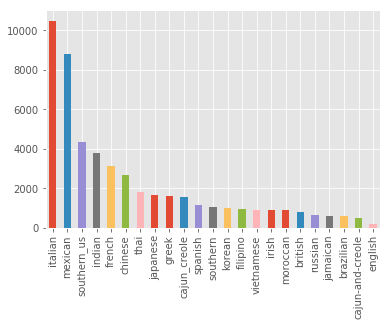

In [21]:
trainData['cuisine'].value_counts().plot(kind='bar')

Creating a table showing the 10 most common ingredients for each cuisine.

In [22]:
from collections import Counter

counters = {}
for cuisine in trainData['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (trainData['cuisine'] == cuisine)
    for ingredients in trainData[indices]['ingredients']:
        counters[cuisine].update(ingredients)

In [23]:
top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top{}'.format(i) for i in range(1, 11)])
top10

top1               top2                 top3  \
brazilian                  salt             onions            olive oil   
cajun-and-creole           salt             butter      Cajun seasoning   
southern                   salt        white sugar    all purpose flour   
moroccan                   salt          olive oil         ground cumin   
filipino                   salt             garlic                water   
irish                      salt  all-purpose flour               butter   
english             white sugar             butter                 salt   
russian                    salt              sugar               onions   
french                     salt              sugar    all-purpose flour   
greek                      salt          olive oil        dried oregano   
jamaican                   salt             onions                water   
korean                soy sauce         sesame oil               garlic   
spanish                    salt          olive oil        garlic cloves   
thai                 fish sauce             garlic                 salt   
vietnamese           fish sauce              sugar                 salt   
indian                     salt             onions         garam masala   
italian                    salt          olive oil        garlic cloves   
mexican                    salt             onions         ground cumin   
japanese              soy sauce               salt                mirin   
southern_us                salt             butter    all-purpose flour   
chinese               soy sauce         sesame oil                 salt   
british                    salt  all-purpose flour               butter   
cajun_creole               salt             onions               garlic   

                                    top4                   top5  \
brazilian                           lime                  water   
cajun-and-creole       all purpose flour    ground black pepper   
southern                          butter                  water   
moroccan                          onions        ground cinnamon   
filipino                          onions              soy sauce   
irish                             onions                  sugar   
english                all purpose flour                   milk   
russian                all-purpose flour             sour cream   
french                   unsalted butter              olive oil   
greek                      garlic cloves   feta cheese crumbles   
jamaican                          garlic        ground allspice   
korean                      green onions                  sugar   
spanish           extra-virgin olive oil                 onions   
thai                        coconut milk          vegetable oil   
vietnamese                        garlic                  water   
indian                             water        ground turmeric   
italian           grated parmesan cheese                 garlic   
mexican                           garlic              olive oil   
japanese                           sugar                  water   
southern_us                        sugar             large eggs   
chinese                      corn starch                  sugar   
british                             milk                   eggs   
cajun_creole           green bell pepper                 butter   

                                    top6                    top7  \
brazilian                  garlic cloves                  garlic   
cajun-and-creole               olive oil                   water   
southern                 vanilla extract                    eggs   
moroccan                   garlic cloves                   water   
filipino                          pepper                     oil   
irish                           potatoes             baking soda   
english                             eggs       all purpose flour   
russian                             eggs                   water   
frenc

We can see from the above that the presence of salt tells us very little, but something like fish sauce can narrow down the probable cuisines considerably. To see how big this effect is, we visualise the percentage of recipes that our most common ingredients are found in, for each cuisine.

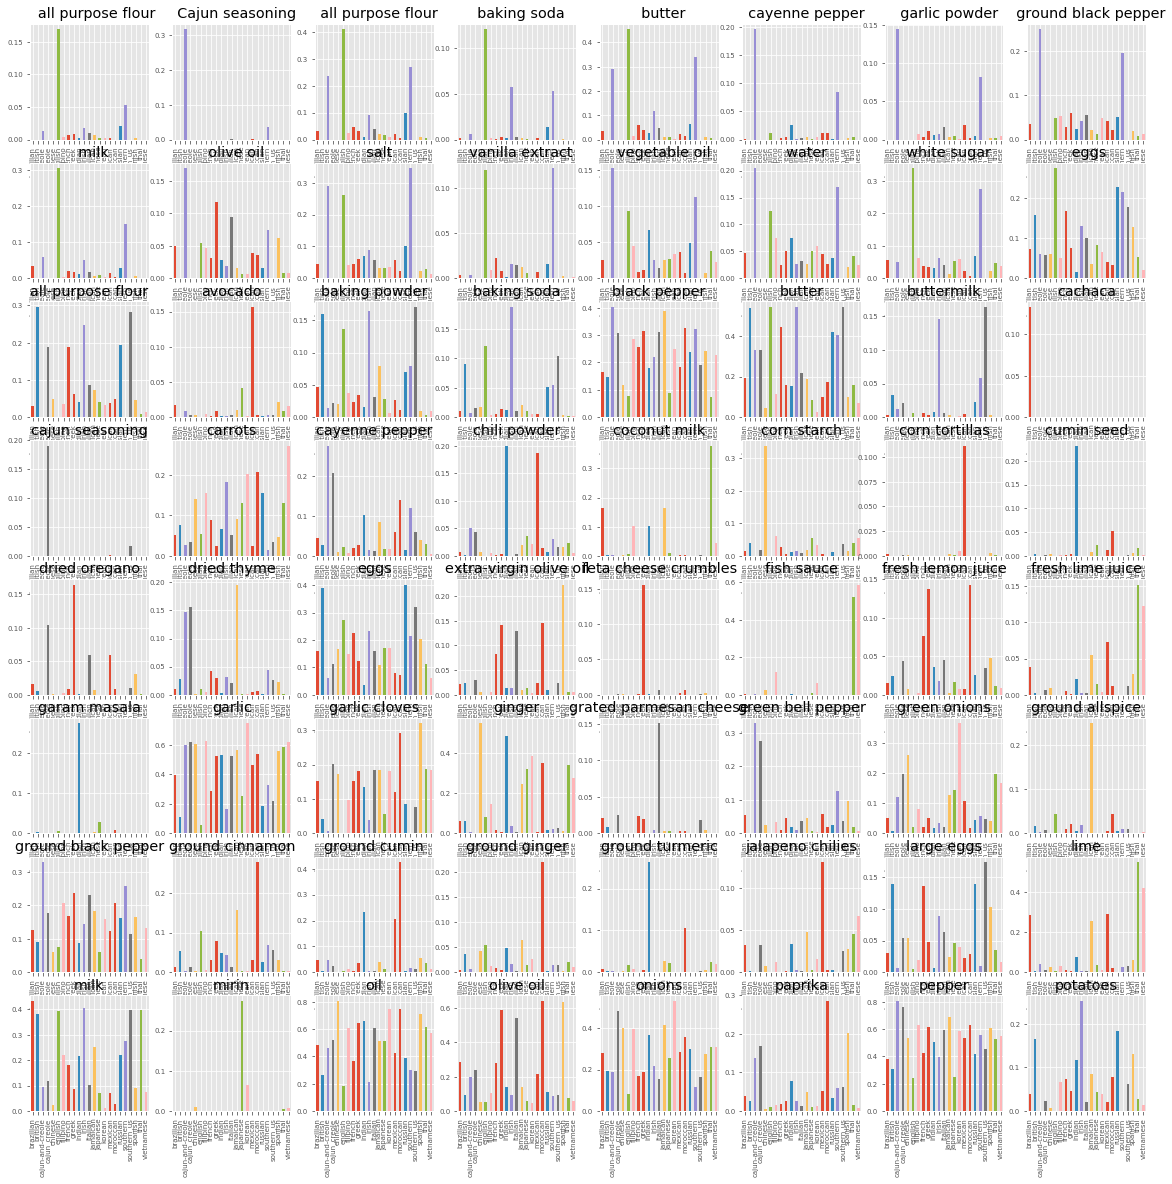

In [24]:
import numpy as np

unique = np.unique(top10.values.ravel())
trainData['all_ingredients'] = trainData['ingredients'].map(";".join)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))
for ingredient, ax_index in zip(unique, range(64)):
    indices = trainData['all_ingredients'].str.contains(ingredient)
    #indices = any(ingredient in s for s in trainData['ingredients'])
    relative_freq = (trainData[indices]['cuisine'].value_counts() / trainData['cuisine'].value_counts())
    relative_freq.plot(kind='bar', ax=axes.ravel()[ax_index], fontsize=7, title=ingredient)


This indicates the above statement in a more understandable form - ingredients like water, butter and oil don't do much to differentiate between cuisines, whereas sake, feta cheese and garam masala are exceptionally informative.

This is, perhaps, not too surprising, and does indicate that a Naive Bayes classifier should perform very well on this dataset. 

### Section 3: Classifier Implementation

On the single fold of data tested (seed=37), the six classifiers implemented below achieved the following accuracy. Benchmarks are shown in brackets:

**KNN** - 64.44% *(60.75)* <br>
**Decision Tree** - 63.78% *(62.59)* <br>
**Naive Bayes** - 72.57% *(73.25)* <br>
**Random Forest** - 71.16% *(74.13)* <br>
**Logistic Regression** - 78.37% *(81.25)* <br>
**SVM (LinearSVC)** - 77.05% *(81.32)* <br>

For reference, on the test set a score of 82.07% would have been sufficient for a Top-10 placement, while the competition winner scored 83.02%.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(trainData['all_ingredients'], trainData['cuisine'], test_size=0.2, random_state=37)

In [26]:
cv = CountVectorizer()
X_train_vec = cv.fit_transform(X_train.values)
X_test_vec = cv.transform(X_test.values)
X_train_vec.shape
#X_test_vec.shape

(39869, 3862)

In [27]:
print(list(cv.vocabulary_.keys())[:100])

['olive', 'oil', 'black', 'olives', 'crusty', 'rolls', 'tomatoes', 'fennel', 'bulb', 'salt', 'ground', 'pepper', 'wine', 'vinegar', 'fresh', 'parsley', 'capers', 'garlic', 'chickpeas', 'guajillo', 'chiles', 'hominy', 'onions', 'cloves', 'pork', 'shoulder', 'lower', 'sodium', 'chicken', 'broth', 'water', 'chipotles', 'in', 'adobo', 'cumin', 'kosher', 'canola', 'tilapia', 'fillets', 'chili', 'powder', 'mango', 'promise', 'buttery', 'spread', 'corn', 'tortillas', 'lime', 'juice', 'jicama', 'chopped', 'cilantro', 'slices', 'bacon', 'pancetta', 'hot', 'sweet', 'peppers', 'red', 'flakes', 'me', 'cubed', 'cooked', 'potaes', 'eggs', 'beaten', 'ounces', 'crumbled', 'feta', 'cheese', 'nuts', 'honey', 'shallots', 'sea', 'onion', 'low', 'leeks', 'farro', 'celery', 'carrots', 'peppercorns', 'vegetable', 'star', 'anise', 'duck', 'thyme', 'sprigs', 'ruby', 'port', 'grated', 'parmesan', 'butter', 'dry', 'rendered', 'fat', 'plain', 'flour', 'potatoes', 'lamb', 'bouillon']


The below encodes the labels, mapping brazilian:vietnamese -> 0:19

In [28]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
y_train_vec = enc.fit_transform(y_train.values)
y_test_vec = enc.transform(y_test.values)
y_train_vec[:100]

array([ 7, 15, 15, 11,  7,  1, 15, 15,  8,  7, 11,  7,  8, 19, 17, 11, 11,
       22, 12, 10,  4,  9,  7, 16,  8, 11, 15, 11, 15, 11, 15, 11, 20,  4,
       15,  7,  7, 15,  9,  2, 11,  9, 16, 19,  7,  9, 18, 19,  7, 15,  1,
       11,  7, 11, 17,  7, 20, 15, 11, 11, 13,  1, 16, 19,  9, 15,  4, 22,
       15, 11, 13,  4, 19,  8, 15, 11,  6,  8, 13, 13, 15, 15, 11,  9, 19,
        8, 13, 15, 19, 19,  9, 21, 19,  4,  7, 19, 15, 15,  8,  7])

Lastly it's worth checking our validation fold has a representative number of each cuisine in the set. We will of course perform later refolding and validation, but don't want to invalidate the results we'll be commenting on. The graph appears to be showing roughly the same proportions as present in the initial trainData set, so we can proceed.

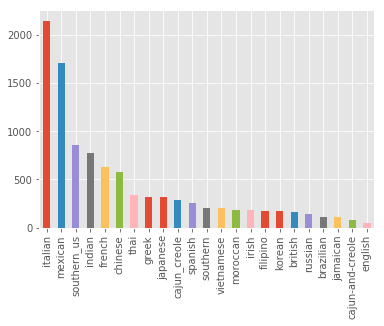

In [29]:
y_test.value_counts().plot(kind='bar')

#### Section 3.1: KNN Classifer

In [30]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=21)
neigh.fit(X_train_vec, y_train_vec)

neigh.score(X_test_vec, y_test_vec)

0.6242977528089888

In [32]:
neigh_pred = neigh.predict(X_test_vec)
print(classification_report(y_test_vec, neigh_pred, target_names=cuisine))

             precision    recall  f1-score   support

          c       0.33      0.36      0.34       114
          a       0.34      0.21      0.26       164
          j       0.40      0.07      0.12        83
          u       0.60      0.49      0.54       282
          n       0.76      0.69      0.72       573
          _       0.50      0.02      0.04        46
          c       0.42      0.50      0.46       177
          r       0.37      0.45      0.40       629
          e       0.71      0.36      0.48       316
          o       0.77      0.73      0.75       771
          l       0.62      0.38      0.47       178
          e       0.61      0.86      0.72      2146

avg / total       0.63      0.62      0.60      9968



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 23, does not match size of target_names, 12
  .format(len(labels), len(target_names))


#### Section 3.2: Decision Tree Classifer

In [33]:
from sklearn import tree

dec = tree.DecisionTreeClassifier()
dec.fit(X_train_vec, y_train_vec)

dec.score(X_test_vec, y_test_vec)

0.6494783306581059

In [35]:
dec_pred = dec.predict(X_test_vec)
print(classification_report(y_test_vec, dec_pred, target_names=cuisine))

             precision    recall  f1-score   support

          c       0.44      0.40      0.42       114
          a       0.30      0.25      0.27       164
          j       0.19      0.18      0.19        83
          u       0.47      0.53      0.50       282
          n       0.70      0.66      0.68       573
          _       0.22      0.15      0.18        46
          c       0.42      0.44      0.43       177
          r       0.45      0.47      0.46       629
          e       0.61      0.61      0.61       316
          o       0.77      0.79      0.78       771
          l       0.45      0.46      0.45       178
          e       0.77      0.79      0.78      2146

avg / total       0.64      0.65      0.65      9968



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 23, does not match size of target_names, 12
  .format(len(labels), len(target_names))


Code courtesy of Stack Overflow - aim is to convert the above decision tree into a pythonic if-else statement so we can examine the decisions being made. Output is considerably too lengthy for easy reading, but we can see the low entropy of outputs at nearly all of the leaf nodes, indicating this tree is probably overfitting.

In [36]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [37]:
tree_to_code(dec,cv.get_feature_names())

def tree(00, 10, 100, 14, 15, 25, 33, 40, 43, 95, abalone, abbamele, about, absinthe, abuelita, abura, acai, accding, accent, accompaniment, achar, achiote, acid, acini, ackee, acn, acorn, across, acting, activ, active, added, addition, additional, adjust, adobo, adzuki, against, agar, agave, age, aged, ahi, aioli, ajinomoto, ajwain, aka, al, alaskan, albace, albacore, alcohol, ale, aleppo, alexia, alfalfa, alfredo, all, alligar, allspice, almond, almonds, almost, alphabet, alum, aluminum, amaranth, amaret, amaretti, amarettini, amaretto, amarillo, amaro, amber, amberjack, amcho, amchur, america, american, amino, aminos, ammonium, amount, ampalaya, an, anaheim, anasazi, ancho, anchovies, anchovy, and, andouille, anejo, ange, angel, anges, anglaise, angled, angostura, angus, anise, anisette, anjou, annat, annatto, any, aonori, apart, aperitif, apple, apples, applesauce, applewood, apricot, apricots, aquavit, arak, arame, arbio, arbol, arborio, arctic, arepa, argo, arhar, armagnac, aroma

                                                                                                                                                                                                                                                                          if seeds <= 0.5:
                                                                                                                                                                                                                                                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                                                                                                                                                          else:  # if seeds > 0.5
                                                                               

                                                                                                                                                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                                                                      else:  # if lemon > 0.5
                                                                                                                                                                                        if pepper <= 0.5:
                                                                                                                                                                                          if whipping <= 0.5:
                                                                                                                        

                                                                                                                                                                          if pie <= 0.5:
                                                                                                                                                                            if blue <= 0.5:
                                                                                                                                                                              if juice <= 1.5:
                                                                                                                                                                                if cnstarch <= 0.5:
                                                                                                                                                                                  if poppyseed <= 0.5:
                                         

                                                                                                                          return [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                    else:  # if salt > 0.5
                                                                                                                      if capers <= 0.5:
                                                                                                                        if bell <= 0.5:
                                                                                                                          if chopped <= 0.5:
                                                                                                                            if garlic <= 0.5:
                                                                                                        

                                                                                                                                                            else:  # if cream > 0.5
                                                                                                                                                              return [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                                          else:  # if cloves > 0.5
                                                                                                                                                            return [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                                        else:  # if chi

                                                                                                                                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
                                                                                                                                                            else:  # if cashew > 0.5
                                                                                                                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                                          else:  # if channa > 0.5
                                                                                                                                                            return

                                                                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                            else:  # if bay > 0.5
                                                                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0.]]
                                                                                                          else:  # if diced > 0.5
                                                                                                            return [[0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                      else:  # if green > 0.5
                                        

                                                                                                  else:  # if dijon > 0.5
                                                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                                                                else:  # if cayenne > 0.5
                                                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
                                                                                              else:  # if fresh > 1.0
                                                                                                return [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                            else:  # if 

                                                                    if cheese <= 0.5:
                                                                      if large <= 0.5:
                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                      else:  # if large > 0.5
                                                                        return [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                    else:  # if cheese > 0.5
                                                                      return [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 49.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.]]
                                                                  else:  # if cornmeal > 0.5
                                                                    

                                                                              else:  # if raspberry > 0.5
                                                                                return [[0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                            else:  # if caster > 0.5
                                                                              return [[0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                          else:  # if whiskey > 0.5
                                                                            if raisins <= 0.5:
                                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                            else:  # if raisins > 0.5
                    

                                                                                                                      else:  # if salt > 0.5
                                                                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]]
                                                                                                                  else:  # if spanish > 0.5
                                                                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                else:  # if gram > 0.5
                                                                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                      else:  # if rice > 0.5
                                                        if sliced <= 0.5:
                                                          if scallions <= 0.5:
                                                            if water <= 0.5:
                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.]]
                                                            else:  # if water > 0.5
                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
                                                          else:  # if scallions > 0.5
                                                            if anchovies <= 0.5:
                    

                                                                                                                                                                                                                            if salt <= 0.5:
                                                                                                                                                                                                                              if skinless <= 0.5:
                                                                                                                                                                                                                                if shredded <= 0.5:
                                                                                                                                                                                                                                  if melted <= 0.5:
                                  

                                                                                                      if cold <= 0.5:
                                                                                                        if all <= 0.5:
                                                                                                          if chocolate <= 0.5:
                                                                                                            if heavy <= 0.5:
                                                                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0.]]
                                                                                                            else:  # if heavy > 0.5
                                                                                                              return [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

                                                                                                        else:  # if egg > 0.5
                                                                                                          return [[0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                      else:  # if purpose > 0.5
                                                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                  else:  # if eggs > 0.5
                                                                                                    if glaze <= 0.5:
                                                                                                      if large <= 0.5:
                   

                                                                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                        else:  # if barley > 0.5
                                                                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                      else:  # if peas > 0.5
                                                                                        return [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                    else:  # if roast > 0.5
                                                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.

                                                                                                                                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                                                              else:  # if parsley > 0.5
                                                                                                                                                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                                                            else:  # if sugar > 0.5
                                                                                          

                                                                                        return [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                  else:  # if chocolate > 0.5
                                                                                    if sugar <= 1.5:
                                                                                      return [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                    else:  # if sugar > 1.5
                                                                                      if granulated <= 0.5:
                                                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                       

                                                                    return [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                  else:  # if red > 0.5
                                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                else:  # if ground > 0.5
                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                            else:  # if sauce > 0.5
                                                              if stock <= 0.5:
                                                                if cayenne <= 0.5:
                                                                  if small <= 0.5:
                                                    

                                                                if herb <= 0.5:
                                                                  if fajita <= 0.5:
                                                                    if mushrooms <= 0.5:
                                                                      if lime <= 0.5:
                                                                        if cloves <= 0.5:
                                                                          if tomato <= 1.5:
                                                                            if bottle <= 0.5:
                                                                              if rice <= 0.5:
                                                                                if sherry <= 0.5:
                                                                                  if coriander <= 0.5:
                                                                                    if ext

                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                      else:  # if minced > 0.5
                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                  else:  # if pasta > 0.5
                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                              else:  # if free > 1.5
                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                            else:  # if whipping > 0.5
                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                          else:  

                                    else:  # if steak > 0.5
                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 0.]]
                                  else:  # if onions > 0.5
                                    if daikon <= 0.5:
                                      if anise <= 0.5:
                                        if sesame <= 0.5:
                                          if scallions <= 0.5:
                                            if oyster <= 0.5:
                                              if fillets <= 0.5:
                                                if sprouts <= 0.5:
                                                  if scallops <= 0.5:
                                                    if flour <= 0.5:
                                                      if pak <= 0.5:
                                                        if heads <= 0.5:
                                                          

                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                else:  # if strawberries > 0.5
                                                  if flour <= 0.5:
                                                    return [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                  else:  # if flour > 0.5
                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                              else:  # if habanero > 0.5
                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
                                            else:  # if greens > 0.5
                                              return [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 7. 0. 0. 0. 0. 0. 0. 0.]]
                                        else:  # if dark > 0.5
                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                    else:  # if vegetable > 0.5
                                      if margarine <= 0.5:
                                        if smoked <= 0.5:
                                          if cream <= 0.5:
                                            if red <= 0.5:
                                              return [[0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                            else:  # if red > 0.5
                                              if threads <= 0.5:
                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
         

                                                                                                                                              if extra <= 0.5:
                                                                                                                                                if leaf <= 0.5:
                                                                                                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                                                                                                                else:  # if leaf > 0.5
                                                                                                                                                  if red <= 0.5:
                                                                                                                               

                                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                            else:  # if bulb > 0.5
                                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                          else:  # if chili > 0.5
                                                                            if bay <= 0.5:
                                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0.]]
                                                                            else:  # if bay > 0.5
                                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0

                                                                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                          else:  # if medallions > 0.5
                                                                                            if shallot <= 0.5:
                                                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                            else:  # if shallot > 0.5
                                                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                        else:  # if anise > 0.5
                

                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0.]]
                                                                else:  # if hot > 0.5
                                                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                            else:  # if scallions > 0.5
                                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                          else:  # if small > 0.5
                                                            return [[0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                    else:  # if sauce > 0.5
                                                      if cloves <= 0.5:
                      

                                                      else:  # if sheets > 0.5
                                                        return [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                  else:  # if worcestershire > 0.5
                                                    if lemon <= 0.5:
                                                      if chile <= 0.5:
                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                                                      else:  # if chile > 0.5
                                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
                                                    else:  # if lemon > 0.5
                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
  

                                  else:  # if scallions > 0.5
                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                else:  # if salmon > 0.5
                                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
                              else:  # if ginger > 0.5
                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
                          else:  # if curry > 0.5
                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 7. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                      else:  # if cajun > 0.5
                        if can <= 0.5:
                          if in <= 0.5:
                            if dry <= 0.5:
                              if pounds <= 0.5:
                                if pitted <= 0.5:
                                  if chorizo <= 0.5:
       

                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                  else:  # if halloumi > 0.5
                                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                else:  # if pompeian > 0.5
                                                  return [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                              else:  # if pepper > 0.5
                                                if sage <= 0.5:
                                                  if sweet <= 0.5:
                                                    if black <= 0.5:
                                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                               

                                                  return [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                          else:  # if garlic > 0.5
                                            if chorizo <= 0.5:
                                              if sugar <= 0.5:
                                                if chickpeas <= 0.5:
                                                  if marjoram <= 0.5:
                                                    if butter <= 0.5:
                                                      if thyme <= 0.5:
                                                        if water <= 0.5:
                                                          if matillos <= 0.5:
                                                            if shrimp <= 0.5:
                                                              if powder <= 1.5:
                                                                return [[ 0.  0.  0.  0.

                          return [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                      else:  # if red > 0.5
                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0.]]
                    else:  # if coconut > 0.5
                      if paste <= 0.5:
                        return [[4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                      else:  # if paste > 0.5
                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.]]
                  else:  # if sauce > 0.5
                    if water <= 0.5:
                      if carrot <= 0.5:
                        if vietnamese <= 0.5:
                          if radishes <= 0.5:
                            if bones <= 0.5:
                              if nuoc <= 0.5:
                                if sugar <= 1.5:
                                  if hard <= 0.5:
      

                              if crustless <= 0.5:
                                return [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                              else:  # if crustless > 0.5
                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
                          else:  # if jalapeno > 0.5
                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0.]]
                        else:  # if short > 0.5
                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.]]
                      else:  # if chili > 0.5
                        if lime <= 0.5:
                          return [[0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                        else:  # if lime > 0.5
                          if lemongrass <= 0.5:
                            return [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0

                                                return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                            else:  # if frozen > 0.5
                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
                                          else:  # if cloves > 0.5
                                            return [[0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                      else:  # if white > 0.5
                                        if sirloin <= 0.5:
                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0.]]
                                        else:  # if sirloin > 0.5
                                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
                                    else:  # if salt > 

                                    if ginger <= 0.5:
                                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2.]]
                                    else:  # if ginger > 0.5
                                      if chilies <= 0.5:
                                        return [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                      else:  # if chilies > 0.5
                                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
                                  else:  # if vegetable > 0.5
                                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0.]]
                                else:  # if salt > 0.5
                                  return [[0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                              else:  # if shallots > 0.5
  

                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                          else:  # if sodium > 0.5
                                            if chicken <= 0.5:
                                              return [[0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                            else:  # if chicken > 0.5
                                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
                                        else:  # if soba > 0.5
                                          if breasts <= 0.5:
                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                          else:  # if breasts > 0.5
                                            return [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

                      else:  # if creole > 0.5
                        if parsley <= 0.5:
                          if salt <= 0.5:
                            if sour <= 0.5:
                              return [[0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                            else:  # if sour > 0.5
                              return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
                          else:  # if salt > 0.5
                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
                        else:  # if parsley > 0.5
                          return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                    else:  # if balsamic > 0.5
                      if garlic <= 0.5:
                        return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                      else:  # if garlic > 0.5
  

                                                                                                                                        if eggs <= 0.5:
                                                                                                                                          if arugula <= 0.5:
                                                                                                                                            return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                                                                          else:  # if arugula > 0.5
                                                                                                                                            return [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                                                                                       

                          return [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                      else:  # if trimmed > 0.5
                        return [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
                    else:  # if processed > 0.5
                      return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                  else:  # if sweet > 0.5
                    return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                else:  # if sour > 0.5
                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
              else:  # if eggs > 0.5
                if halves <= 0.5:
                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
                else:  # if halves > 0.5
                  return [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
     

#### Section 3.3: Naive Bayes Classifer

In [38]:
from sklearn.naive_bayes import MultinomialNB

bayes = MultinomialNB()
#todense() method used to coerce ndarray from csr (sparse) to dense format
#only seemed to be throwing errors on the training matrix, unsure why
bayes.fit(X_train_vec.todense(), y_train_vec)

bayes.score(X_test_vec.todense(), y_test_vec)

0.7031500802568218

In [40]:
bayes_pred = bayes.predict(X_test_vec.todense())
print(classification_report(y_test_vec, bayes_pred, target_names=cuisine))

             precision    recall  f1-score   support

          c       0.46      0.27      0.34       114
          a       0.35      0.37      0.36       164
          j       0.25      0.51      0.33        83
          u       0.51      0.74      0.60       282
          n       0.74      0.87      0.80       573
          _       0.50      0.15      0.23        46
          c       0.71      0.34      0.46       177
          r       0.47      0.55      0.51       629
          e       0.69      0.67      0.68       316
          o       0.85      0.89      0.87       771
          l       0.63      0.47      0.54       178
          e       0.85      0.74      0.79      2146

avg / total       0.73      0.70      0.70      9968



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 23, does not match size of target_names, 12
  .format(len(labels), len(target_names))


#### Section 3.4: Random Forest Classifer

In [41]:
from sklearn.ensemble import RandomForestClassifier

frst = RandomForestClassifier(random_state=37)
frst.fit(X_train_vec, y_train_vec)

frst.score(X_test_vec, y_test_vec)

0.7027487961476726

In [43]:
frst_pred = frst.predict(X_test_vec)
print(classification_report(y_test_vec, frst_pred, target_names=cuisine))

             precision    recall  f1-score   support

          c       0.63      0.42      0.51       114
          a       0.35      0.30      0.32       164
          j       0.20      0.14      0.17        83
          u       0.58      0.57      0.57       282
          n       0.70      0.84      0.76       573
          _       0.25      0.11      0.15        46
          c       0.58      0.43      0.50       177
          r       0.49      0.54      0.51       629
          e       0.75      0.61      0.67       316
          o       0.78      0.91      0.84       771
          l       0.68      0.47      0.55       178
          e       0.72      0.88      0.79      2146

avg / total       0.69      0.70      0.69      9968



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 23, does not match size of target_names, 12
  .format(len(labels), len(target_names))


#### Section 3.5: Logistic Regression Classifer

In [44]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X_train_vec, y_train_vec)

logistic.score(X_test_vec, y_test_vec)

0.7770866773675762

Text(0.5,43.475,'Predicted label')

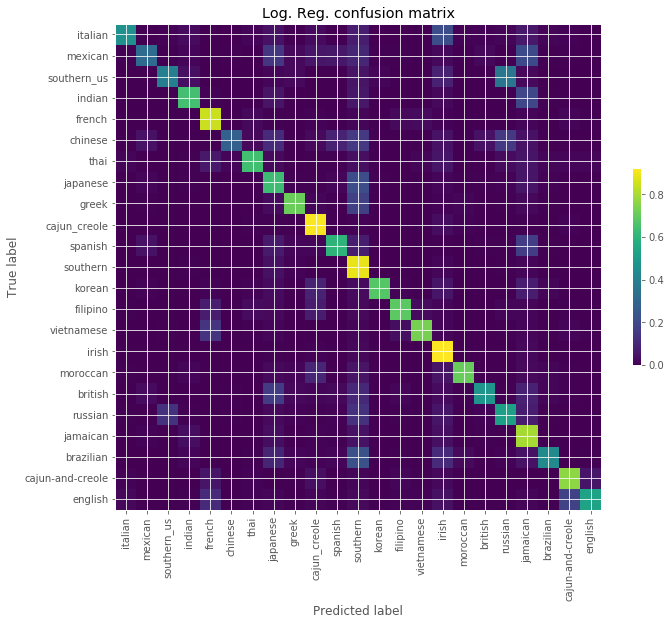

In [45]:
plt.figure(figsize=(10, 10))

log_cm = confusion_matrix(y_test_vec, logistic.predict(X_test_vec))
log_cm_normalized = log_cm.astype('float') / log_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(log_cm_normalized, interpolation='nearest')
plt.title("Log. Reg. confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = trainData['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [46]:
log_pred = logistic.predict(X_test_vec)
print(classification_report(y_test_vec, log_pred, target_names=cuisines))

                  precision    recall  f1-score   support

         italian       0.70      0.46      0.56       114
         mexican       0.56      0.32      0.41       164
     southern_us       0.47      0.40      0.43        83
          indian       0.74      0.65      0.69       282
          french       0.81      0.85      0.83       573
         chinese       0.65      0.28      0.39        46
            thai       0.74      0.64      0.69       177
        japanese       0.59      0.64      0.61       629
           greek       0.80      0.72      0.76       316
    cajun_creole       0.85      0.91      0.88       771
         spanish       0.71      0.60      0.65       178
        southern       0.80      0.89      0.84      2146
          korean       0.86      0.68      0.76       112
        filipino       0.83      0.69      0.75       314
      vietnamese       0.79      0.73      0.76       175
           irish       0.87      0.92      0.90      1710
        moroc

Although the raw accuracy score looks good, the confusion matrix and particularly the analysis of the recall show a different story for some cuisines. Italian, Mexican and Filipino dishes are more likely to be classified as other cuisines than they are themselves, indicating that there may be few stand-out ingredients for these cuisines.

#### Section 3.6: SVM Classifer

In [47]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC(random_state=37)
lsvc.fit(X_train_vec, y_train_vec)

lsvc.score(X_test_vec, y_test_vec)

0.7653491171749599

Text(0.5,43.475,'Predicted label')

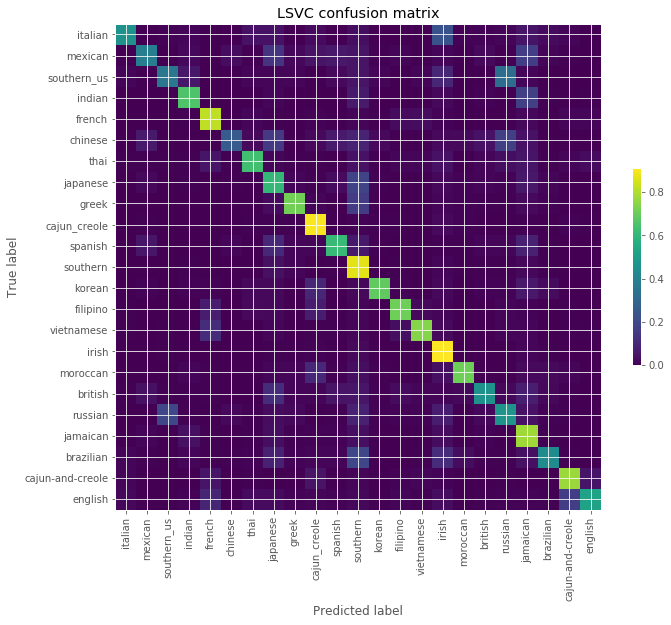

In [48]:
plt.figure(figsize=(10, 10))

lsvc_cm = confusion_matrix(y_test_vec, lsvc.predict(X_test_vec))
lsvc_cm_normalized = lsvc_cm.astype('float') / lsvc_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(lsvc_cm_normalized, interpolation='nearest')
plt.title("LSVC confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = trainData['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [49]:
lsvc_pred = lsvc.predict(X_test_vec)
print(classification_report(y_test_vec, lsvc_pred, target_names=cuisines))

                  precision    recall  f1-score   support

         italian       0.63      0.46      0.54       114
         mexican       0.52      0.39      0.44       164
     southern_us       0.34      0.36      0.35        83
          indian       0.69      0.66      0.68       282
          french       0.81      0.82      0.82       573
         chinese       0.38      0.26      0.31        46
            thai       0.67      0.63      0.65       177
        japanese       0.59      0.61      0.60       629
           greek       0.76      0.72      0.74       316
    cajun_creole       0.84      0.90      0.87       771
         spanish       0.62      0.62      0.62       178
        southern       0.82      0.87      0.85      2146
          korean       0.79      0.69      0.73       112
        filipino       0.80      0.71      0.75       314
      vietnamese       0.75      0.74      0.75       175
           irish       0.88      0.91      0.89      1710
        moroc

#### Bonus section: implementing pipelines from andrew_bag_of_words to compare results

In [60]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', 
                                                   penalty='l2',
                                                   alpha=1e-3,
                                                   n_iter=5,
                                                   random_state=42)),
                         ])

text_clf_svm.fit(X_train, y_train)
text_clf_svm.score(X_test, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


0.6872993579454254

In [61]:
pipe_svm_pred = text_clf_svm.predict(X_test)
print(classification_report(y_test, pipe_svm_pred, target_names=cuisine))

             precision    recall  f1-score   support

          c       0.60      0.24      0.34       114
          a       0.50      0.08      0.14       164
          j       0.44      0.10      0.16        83
          u       0.66      0.54      0.59       282
          n       0.69      0.88      0.78       573
          _       0.21      0.13      0.16        46
          c       0.87      0.27      0.41       177
          r       0.60      0.35      0.44       629
          e       0.76      0.51      0.61       316
          o       0.72      0.92      0.81       771
          l       0.67      0.35      0.46       178
          e       0.68      0.91      0.78      2146

avg / total       0.69      0.69      0.65      9968



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 23, does not match size of target_names, 12
  .format(len(labels), len(target_names))


In [62]:
from sklearn.multiclass import OneVsRestClassifier

pipe_nb = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', OneVsRestClassifier(MultinomialNB()))])

pipe_nb.fit(X_train, y_train)
pipe_nb.score(X_test,y_test)

0.6594101123595506

In [63]:
pipe_nb_pred = pipe_nb.predict(X_test)
print(classification_report(y_test, pipe_nb_pred, target_names=cuisines))

                  precision    recall  f1-score   support

         italian       1.00      0.12      0.22       114
         mexican       0.70      0.04      0.08       164
     southern_us       0.40      0.02      0.05        83
          indian       0.83      0.43      0.56       282
          french       0.66      0.90      0.76       573
         chinese       0.00      0.00      0.00        46
            thai       0.96      0.12      0.22       177
        japanese       0.52      0.42      0.46       629
           greek       0.94      0.32      0.48       316
    cajun_creole       0.76      0.91      0.83       771
         spanish       0.87      0.15      0.26       178
        southern       0.63      0.90      0.74      2146
          korean       1.00      0.15      0.26       112
        filipino       0.93      0.55      0.69       314
      vietnamese       0.93      0.35      0.51       175
           irish       0.74      0.92      0.82      1710
        moroc

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


This is actually the most interesting result so far. The high precision and horrendous recall on Italian, British, Jamaican and Brazilian suggest that the classifier is barely predicting these cuisines at all. That said, the f-score is very high for other cuisines such as Greek, Indian, Thai and Moroccan, suggesting that this could be used as part of a One vs All classifier ensemble, specifically for dealing with those cuisines.

Text(0.5,43.475,'Predicted label')

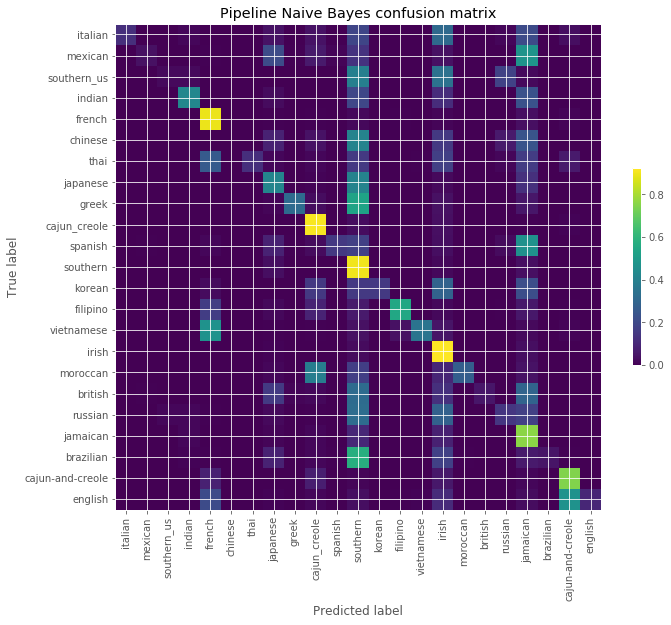

In [64]:
plt.figure(figsize=(10, 10))

pipe_nb_cm = confusion_matrix(y_test, pipe_nb.predict(X_test))
pipe_nb_cm_normalized = pipe_nb_cm.astype('float') / pipe_nb_cm.sum(axis=1)[:, np.newaxis]

plt.imshow(pipe_nb_cm_normalized, interpolation='nearest')
plt.title("Pipeline Naive Bayes confusion matrix")
plt.colorbar(shrink=0.3)
cuisines = trainData['cuisine'].value_counts().index
tick_marks = np.arange(len(cuisines))
plt.xticks(tick_marks, cuisines, rotation=90)
plt.yticks(tick_marks, cuisines)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')